# Proyecto de Visión Artificial y Reconocimiento de Patrones.

## Reconocimiento Visual de Videojuegos
* Pablo Oliva García
* Alberto Pérez Álvarez

## 1. Importaciones y declaración de flags

In [ ]:
import os

# Configuración de entorno
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from transformers import TFAutoModel
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib
import time
from sklearn.metrics import classification_report, confusion_matrix
import gc 
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras import Model

#from tensorflow.keras import mixed_precision # La GPU de Kaggle no lo soporta

In [ ]:
FAST_EXEC = False
FAST_EPOCHS = 1

if FAST_EXEC:
    print("MODO RÁPIDO ACTIVADO (FAST_EXEC = True)")
    print("   Todas las épocas de entrenamiento se reducen. Se usará el dataset pequeño.")
    
    # Dataset pequeño
    KAGGLE_PATH = '/kaggle/input/videojuegos-small-tfrec/tfrecords_small_dataset'
    LOCAL_PATH = '../datasets/tfrecords_small_dataset'     # Ruta en local.

    class_names = [
        'AMONG_US', 'CONTRA', 'ELDEN_RING', 'GOD_OF_WAR_1', 'GTA_SAN_ANDREAS', 'GTA_V', 'HADES', 
        'HOLLOW_KNIGHT', 'MARIO_GALAXY', 'MARIO_KART_8', 'MINECRAFT', 'NEW_SUPER_MARIO_BROS', 
        'POKEMON_X_Y', 'RED_DEAD_REDEMPTION_2', 'SILENT_HILL_2', 'UNDERTALE'
    ]
else: 
    # Dataset estándar
    KAGGLE_PATH = '/kaggle/input/videojuegos-tfrec/tfrecords_dataset'
    LOCAL_PATH = '../datasets/tfrecords_dataset' 

    # Deben estar en orden alfabético, igual que como se crearon los TFRecords
    class_names = [
        'AMONG_US', 'CONTRA', 'DEATH_STRANDING', 'ELDEN_RING', 'GOD_OF_WAR_1', 
        'GOD_OF_WAR_2018', 'GTA_SAN_ANDREAS', 'GTA_V', 'HADES', 'HOLLOW_KNIGHT', 
        'HORIZON_FORBBIDEN_WEST', 'HORIZON_ZERO_DAWN', 'MARIO_GALAXY', 'MARIO_KART_8', 
        'MARIO_KART_WORLD', 'MARIO_ODYSSEY', 'MINECRAFT', 'NEW_SUPER_MARIO_BROS', 
        'POKEMON_EMERALD', 'POKEMON_RED', 'POKEMON_X_Y', 'PUNCH_OUT_NES', 
        'RED_DEAD_REDEMPTION_1', 'RED_DEAD_REDEMPTION_2', 'SILENT_HILL_2', 
        'SILKSONG', 'STRAY', 'SUPER_MARIO_64', 'SUPER_MARIO_BROS', 
        'SUPER_MARIO_BROS_WONDER', 'UNDERTALE'
    ]

MODO RÁPIDO ACTIVADO (FAST_EXEC = True)
   Todas las épocas de entrenamiento se reducen. Se usará el dataset pequeño.


In [ ]:
SEED = 2026
tf.random.set_seed(SEED)
np.random.seed(SEED)
#mixed_precision.set_global_policy('mixed_float16') #baja uso de ram usando la mitad de precision en los float. DESCOMENTAR SU IMPORT

print("Versión de TensorFlow:",tf.__version__)
print("Tipo implementacion de Keras:",{tf.keras.__name__})
print(f"GPU Disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

Versión de TensorFlow: 2.19.0
Tipo implementacion de Keras: {'tensorflow.keras'}
GPU Disponible: True


## 2. Carga y partición de los datos

In [ ]:
# Aunque las imágenes son mayores (480x854), el primer modelo (MLP) funciona mejor con 64x64
BATCH_SIZE = 64
IMG_HEIGHT = 64
IMG_WIDTH = 64

# Para saber si es Kaggle y cambiar la ruta del dataset buscamos 'KAGGLE_KERNEL_RUN_TYPE' en el entorno
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
    data_dir = KAGGLE_PATH
    print("Ejecución en Kaggle detectada. Ruta al dataset:",data_dir)
else:
    data_dir = LOCAL_PATH
    print("Ejecución en un entorno local. Ruta al dataset:",data_dir)

data_dir = pathlib.Path(data_dir)

# Verificar estructura y contar archivos tfrec
train_shards = list(data_dir.glob('train/*.tfrec'))
val_shards = list(data_dir.glob('val/*.tfrec'))
test_shards = list(data_dir.glob('test/*.tfrec'))

total_shards = len(train_shards) + len(val_shards) + len(test_shards) #total archivos tfrec

print(f"\nResumen de TFRecords encontrados:")
print(f" ├─ Train shards: {len(train_shards)}")
print(f" ├─ Val shards:   {len(val_shards)}")
print(f" └─ Test shards:  {len(test_shards)}")
print(f"Total archivos .tfrec: {total_shards}")

# Cargar una imagen para ver si se lee bien
if total_shards == 0:
    print("No se han encontrado archivos .tfrec")
else:
    # Cogemos el primer archivo que encontremos
    sample_file = str(train_shards[0])
    
    print(f"\nInspeccionando primer archivo: {os.path.basename(sample_file)}...")
    
    # Leemos un solo registro
    raw_dataset = tf.data.TFRecordDataset(sample_file)
    for raw_record in raw_dataset.take(1):
        # Parseamos manualmente para ver qué hay dentro
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        
        # Extraer etiqueta
        label = example.features.feature['label'].int64_list.value[0]
        
        # Extraer imagen y decodificar
        img_raw = example.features.feature['image'].bytes_list.value[0]
        img_tensor = tf.io.decode_jpeg(img_raw)
        
        print(f" Lectura exitosa")
        print(f" - Etiqueta (int): {label}")
        print(f" - Shape original guardado: {img_tensor.shape}")
        print(f" - Tipo de dato: {img_tensor.dtype}")

Ejecución en Kaggle detectada. Ruta al dataset: /kaggle/input/videojuegos-small-tfrec/tfrecords_small_dataset

Resumen de TFRecords encontrados:
 ├─ Train shards: 4
 ├─ Val shards:   1
 └─ Test shards:  1
Total archivos .tfrec: 6

Inspeccionando primer archivo: train_003.tfrec...
 Lectura exitosa.
 - Etiqueta (int): 12
 - Shape original guardado: (256, 256, 3)
 - Tipo de dato: <dtype: 'uint8'>


### 2.1 Carga de los datos y división en Train/Val/Test

Con el objetivo de garantizar la capacidad de generalización del modelo y evitar el sobreajuste, hemos dividido el conjunto de datos en tres subconjuntos: un 70% destinado al entrenamiento y optimización de parámetros; un 15% para validación, utilizado en el ajuste de hiperparámetros y control del early stopping; y un 15% restante reservado para la prueba (test), permitiendo una evaluación final imparcial.

In [ ]:
# Lectura 
def parse_tfrecord_fn(example, target_size):
    """ Convierte los bytes en tensores para los modelos """

    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3) # la pasamos a jpg, como las que usabamos originalmente
    image = tf.image.resize(image, target_size) # Redimensión para que todas tengan el mismo tamaño
    image = tf.cast(image, tf.float32)
    label = example['label']
    return image, label

def get_dataset_from_tfrecords(tfrecords_dir, batch_size=64, target_size=(224, 224)):
    """Configura cómo se leen los datos intentando maximizar la velocidad """

    filenames = tf.io.gfile.glob(f"{tfrecords_dir}/*.tfrec") # encuentra todos los tfrec
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE) # Paralelo
    
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = dataset.with_options(ignore_order)

    dataset = dataset.map(
        lambda x: parse_tfrecord_fn(x, target_size), 
        num_parallel_calls=tf.data.AUTOTUNE # Lee varios en paralelo
    )
    
    dataset = dataset.shuffle(2000) # Aleatorizamos
    dataset = dataset.batch(batch_size) # Agrupamos segun el batchsize
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [13]:
train_ds = get_dataset_from_tfrecords(os.path.join(data_dir, 'train'), batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))
val_ds = get_dataset_from_tfrecords(os.path.join(data_dir, 'val'), batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))
test_ds = get_dataset_from_tfrecords(os.path.join(data_dir, 'test'), batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))

### 2.2 Calculo de pesos para contrarrestar el desbalanceo de datos

In [ ]:
def calculate_class_weights(train_ds):
    """
    Extrae las etiquetas del dataset de entrenamiento y calcula los pesos
    para equilibrar las clases durante el entrenamiento.
    """
    print("Calculando pesos de las clases... ")
    
    # Mapeamos el dataset para que solo devuelva las etiquetas y. Evita decodificar las imágenes pesadas
    train_labels_only = train_ds.map(lambda x, y: y)
    
    # Ahora iteramos sobre un dataset de solo enteros (muy ligero)
    y_train = []
    for label_batch in train_labels_only:
        y_train.extend(label_batch.numpy())
        
    y_train = np.array(y_train)
    classes = np.unique(y_train)
    
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_train
    )
    
    class_weight_dict = dict(zip(classes, weights))
    
    print("Pesos calculados exitosamente.")
    return class_weight_dict

class_weights = calculate_class_weights(train_ds)

print(f"{'Clase':<10} | {'Peso':<10}")
print("-" * 25)

# formateamos para que no salga todo en una lista
for cs, w in sorted(class_weights.items()):
    print(f"{class_names[cs]:<10} | {w:.4f}")

Calculando pesos de las clases 
Pesos calculados exitosamente.
{np.int64(0): np.float64(0.9695290858725761), np.int64(1): np.float64(1.0115606936416186), np.int64(2): np.float64(0.9915014164305949), np.int64(3): np.float64(0.9749303621169917), np.int64(4): np.float64(1.0115606936416186), np.int64(5): np.float64(0.9943181818181818), np.int64(6): np.float64(0.9957325746799431), np.int64(7): np.float64(1.0115606936416186), np.int64(8): np.float64(0.9859154929577465), np.int64(9): np.float64(1.0043041606886658), np.int64(10): np.float64(1.0248901903367496), np.int64(11): np.float64(1.0416666666666667), np.int64(12): np.float64(1.002865329512894), np.int64(13): np.float64(0.9762900976290098), np.int64(14): np.float64(1.0355029585798816), np.int64(15): np.float64(0.9749303621169917)}


### 2.3 Análisis de las imágenes del dataset

In [ ]:
# Función auxiliar para cargar TODO el dataset junto para visualizarlo entero
def get_full_dataset_for_eda(tfrecords_dir, batch_size=64, target_size=(64, 64)):
    # "*/*.tfrec" busca dentro de train, val y test a la vez
    filenames = tf.io.gfile.glob(f"{tfrecords_dir}/*/*.tfrec")
    
    print(f"Cargando full_ds desde {len(filenames)} archivos TFRecord")
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
    
    dataset = dataset.map(
        lambda x: parse_tfrecord_fn(x, target_size), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Generamos la variable full_ds 
full_ds = get_full_dataset_for_eda(data_dir, batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))

In [ ]:
plt.figure(figsize=(15, 10))

# 'unbatch()' para sacar las imágenes de los paquetes
# 'take(25)' para coger exactamente las que necesitamos
# enumerate para saber en qué posición (i) del subplot estamos
for i, (image, label) in enumerate(train_ds.unbatch().take(25)):  
    ax = plt.subplot(5, 5, i + 1)
    
    # Ya no necesitamos [i] porque 'image' es una sola foto, no un lote
    plt.imshow(image.numpy().astype("uint8"))
    
    # Manejo del label
    label_index = int(label) 
    plt.title(class_names[label_index])
    plt.axis("off")

plt.suptitle("Imagenes de ejemplo del dataset", fontsize=16)
plt.tight_layout()
plt.show()

class_counts = {name: 0 for name in class_names}
for _, labels in full_ds:
    for label in labels:
        class_name = class_names[int(label)]
        class_counts[class_name] += 1

# Lo hacemos con un dataframe, pues es mas facil hacer el plot.
df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(12, 6))
bplot = sns.barplot(x='Count', y='Class', data=df_counts, palette='viridis', hue='Class')
# tenemos que quitar la leyenda manualmente porque da error con legend=False
if bplot.get_legend() is not None:
    bplot.get_legend().remove()

plt.title('Distribucion de imagenes en el dataset', fontsize=16)
plt.xlabel('Numero de imagenes', fontsize=12)
plt.ylabel('Clase', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# añadimos el numero al final de la barra para verlo mejor
for index, value in enumerate(df_counts['Count']):
    plt.text(value + 50, index, str(value), va='center')

plt.tight_layout()
plt.show()

mean_count = df_counts['Count'].mean()
std_count = df_counts['Count'].std()
print(f"Media de imagenes: {mean_count:.2f}")
print(f"Desviacion estandar: {std_count:.2f}")

### 2.4 Definición de métricas, gráficas y pruebas

#### Para cada modelo

In [ ]:
def evaluate_model_metrics(model, test_ds, class_names):
    """ Métricas por clase y matriz de confusión """
    # Generar predicciones para el TEST
    y_true = []
    y_pred = []
    
    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy()) # Verdaderas clases
        y_pred.extend(np.argmax(preds, axis=1)) # PRedichas

    # Reporte de clasificación con todas las metricas
    print(f"\n--- Reporte de Clasificación ---\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Matriz de confusión normalizada
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión Normalizada')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

    return np.array(y_true), np.array(y_pred)

In [ ]:
def plot_confidence_distribution(model, test_ds):
    """ Histograma de confianza """
    confidences = []
    correct_mask = []

    # Predicciones
    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        max_preds = np.max(preds, axis=1) # el modelo devuelve las probabilidades de varias, la mayor es la prediccion
        pred_labels = np.argmax(preds, axis=1) # indice del valor mas alto
        
        confidences.extend(max_preds)
        correct_mask.extend(pred_labels == labels.numpy())

    confidences = np.array(confidences)
    correct_mask = np.array(correct_mask)

    plt.figure(figsize=(10, 6))
    sns.histplot(confidences[correct_mask], color='green', label='Correctas', kde=True, bins=20)
    sns.histplot(confidences[~correct_mask], color='red', label='Incorrectas', kde=True, bins=20)
    plt.title('Distribución de la Confianza del Modelo')
    plt.xlabel('Probabilidad de la clase predicha')
    plt.legend()
    plt.show()

In [ ]:
def measure_latency(model, test_ds):
    """ Latencia  en predecir una imagen """
    # lote de ejemplo
    for images, _ in test_ds.take(1):
        sample_img = images[0:1] # Solo una imagen, no un lote
        break
    
    # Warm-up (la primera suele ser lenta por carga en GPU, la descartamos)
    model.predict(sample_img, verbose=0)
    
    start_time = time.time()
    for _ in range(100):
        model.predict(sample_img, verbose=0)
    end_time = time.time()
    
    avg_latency = (end_time - start_time) / 100 * 1000 # en milisegundos
    print(f"Latencia media de inferencia: {avg_latency:.2f} ms por imagen")

In [ ]:
def get_gradcam_heatmap(model, img_array, last_conv_layer_name):
    """ Mapas de calor para ver dónde se fija el modelo """
    # Creamos un modelo que mapee la imagen a las activaciones de la última capa conv
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, np.argmax(preds[0])]

    # Gradiente de la clase respecto a la salida de la capa conv
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplicamos cada canal por "qué tanto importa" para la clase
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalización para visualización
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def generate_attention_rollout(hf_model_internal, img_tensor):
    """
    Calcula el Attention Rollout usando NumPy para evitar errores de TF.
    Recibe:
        - hf_model_internal: El objeto TFAutoModel (no el wrapper Keras)
        - img_tensor: Tensor ya preprocesado y transpuesto (1, 3, 224, 224)
    """
    # Inferencia para obtener atenciones, tenemos que forzar output_attentions=True
    outputs = hf_model_internal(pixel_values=img_tensor, output_attentions=True, training=False)
    
    # outputs.attentions es una tupla de Tensores. Los pasamos todos a CPU/NumPy
    attentions_list = [att.numpy() for att in outputs.attentions]
    
    # Rollout (Batch, Heads, Tokens, Tokens) -> (1, 12, 197, 197)
    num_tokens = attentions_list[0].shape[-1]
    
    # Matriz identidad
    rollout = np.eye(num_tokens)
    
    for layer_att in attentions_list:
        # Promedio de las cabezas
        layer_att_mean = layer_att.mean(axis=1)[0]
        
        # Conexión Residual + Identidad
        layer_att_mean = layer_att_mean + np.eye(num_tokens)
        
        # dividimos por la suma de cada fila para normalizar
        # Sumamos axis -1 (columnas), keepdims para broadcast
        row_sums = layer_att_mean.sum(axis=-1, keepdims=True)
        layer_att_mean = layer_att_mean / row_sums
        
        rollout = np.matmul(layer_att_mean, rollout)
        
    # El token CLS suele ser el índice 0. Miramos cuánto atiende al resto (1:)
    cls_attention = rollout[0, 1:] 
    
    # Reshape a 2D (14x14)
    grid_size = int(np.sqrt(cls_attention.shape[0])) 
    mask = cls_attention.reshape(grid_size, grid_size)
    
    # Normalización Min-Max 
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    
    return mask

def visualize_model_attention(model_keras, img_original, prep_type, class_names):
    """
    Busca el wrapper, preprocesa la imagen y pone el overlay.
    """
    # Buscar el Wrapper y el modelo interno
    hf_wrapper = None
    for layer in model_keras.layers:
        if isinstance(layer, HFVisionWrapper):
            hf_wrapper = layer
            break
            
    if hf_wrapper is None: return print("No se encontró HFVisionWrapper.")
    if "mobilevit" in hf_wrapper.model_name.lower(): return print(f"Saltando {hf_wrapper.model_name} (No compatible con Rollout).")

    # Como accedemos a una capa inferior hay que replicar las primeras capas
    
    img_tensor = tf.cast(img_original, tf.float32)     # Asegura float32
    
    # Replica build_hf_classifier
    if prep_type == 'neg_one_to_one':
        # x = layers.Rescaling(1./127.5, offset=-1)(x)
        img_tensor = (img_tensor / 127.5) - 1.0
    elif prep_type == 'zero_to_one':
        # x = layers.Rescaling(1./255)(x)
        img_tensor = img_tensor / 255.0
        
    # El modelo hace layers.Permute((3, 1, 2)) -> De (H, W, C) a (C, H, W)
    if img_tensor.shape[-1] == 3:
        img_tensor = tf.transpose(img_tensor, perm=[0, 3, 1, 2])
        
    try:
        mask = generate_attention_rollout(hf_wrapper.hf_model, img_tensor)
    except Exception as e:
        return print(f"Error calculando rollout: {e}")

    # Visualización (Superposición)
    img_h, img_w = img_original.shape[1], img_original.shape[2]     # máscara al tamaño de imagen original
    mask_resized = cv2.resize(mask, (img_w, img_h))
    
    # Cambiamos la imagen a BGR
    img_display = img_original[0].numpy().astype("uint8")
    img_display_bgr = cv2.cvtColor(img_display, cv2.COLOR_RGB2BGR)

    # Heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * mask_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    
    # Overlay
    cam = heatmap + np.float32(img_display_bgr) / 255
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB) # Vuelta a RGB para matplotlib

    # Predicción para el título
    preds = model_keras.predict(img_original, verbose=0)
    pred_label = class_names[np.argmax(preds)]
    conf = np.max(preds) * 100

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_display)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_resized, cmap='jet')
    plt.title("Atención (Raw)")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(cam)
    plt.title(f"Modelo: {hf_wrapper.model_name.split('/')[-1]}\nPred: {pred_label} ({conf:.1f}%)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_history(history, model_name, stop_epoch=None):
    """ Funcion que usamos para imprimir las graficas de los distintos modelos """
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    f1 = history.history['f1_score']
    val_f1 = history.history['val_f1_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc)) 
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training accuracy')
    plt.plot(epochs_range, val_acc, label='Validation accuracy')
    if stop_epoch is not None:
        plt.axvline(x=stop_epoch, color='r', linestyle='--', label=f'Early Stopping (Ep {stop_epoch+1})')
    plt.legend(loc='lower right')
    plt.title(f'{model_name}: Accuracy')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, f1, label='Training f1')
    plt.plot(epochs_range, val_f1, label='Validation f1')
    if stop_epoch is not None:
        plt.axvline(x=stop_epoch, color='r', linestyle='--', label=f'Early Stopping (Ep {stop_epoch+1})')
    plt.legend(loc='lower right')
    plt.title(f'{model_name}: F1-score')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida de training')
    plt.plot(epochs_range, val_loss, label='Perdida de validation')
    plt.legend(loc='upper right')
    plt.title(f'{model_name}: Perdida')
    plt.grid(True)
    
    plt.tight_layout() # Para que se muestren bien con márgenes

    plt.show()

#### Para modelos específicos

In [ ]:
def visualize_gradcam_custom(model, img_array, class_names):
    """ gradcam para la CNN  en específico. Busca automáticamente la última capa Conv2D y genera el mapa de calor
    """
    # Última capa convolucional
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break
    
    if not last_conv_layer_name:
        return print("No se encontró capa Conv2D para Grad-CAM.")

    # Usamos model.inputs directamente. 
    # Keras desactiva DataAugmentation automáticamente en inferencia.
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # Casteamos a float32 pero NO normalizamos (el modelo lo hace)
        img_tensor = tf.cast(img_array, tf.float32)
        
        last_conv_layer_output, preds = grad_model(img_tensor)
        score = tf.reduce_max(preds[0])

    grads = tape.gradient(score, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) # ReLU
    
    if tf.math.reduce_max(heatmap) > 0:
        heatmap = heatmap / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # Visualización
    img_display = img_array[0].numpy().astype('uint8')
    img_display_bgr = cv2.cvtColor(img_display, cv2.COLOR_RGB2BGR)

    heatmap_resized = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    
    superimposed_img = heatmap_colored * 0.4 + img_display_bgr
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    # Predicción para título
    final_preds = model.predict(img_array, verbose=0)
    pred_label = class_names[np.argmax(final_preds)]
    confidence = np.max(final_preds) * 100

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1); plt.imshow(img_display); plt.title("Original"); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(heatmap_resized, cmap='jet'); plt.title(f"Grad-CAM\n({last_conv_layer_name})"); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(superimposed_img); plt.title(f"Pred: {pred_label} ({confidence:.1f}%)"); plt.axis('off')
    plt.tight_layout(); plt.show()

In [ ]:

def plt_transfer_learning(models_history,fine_tune_starts): 
    """
    Versión para transfer learning. Recibe un diccionario con:
    - Key: Nombre del modelo (str)
    - Value: Objeto history del entrenamiento
    Ejemplo: plt_transfer_learning({'VGG16': history_vgg, 'ResNet': history_resnet})
    """
    
    # Iteramos sobre cada modelo en el diccionario
    for model_name, history_tl in models_history.items():
        
        # Extraemos las métricas directamente del historial actual
        acc = history_tl['accuracy']
        val_acc = history_tl['val_accuracy']
        loss = history_tl['loss']
        val_loss = history_tl['val_loss']
        f1 = history_tl['f1_score']
        val_f1 = history_tl['val_f1_score']

        plt.figure(figsize=(12, 10))
        
        # Gráfica de Accuracy 
        plt.subplot(2, 2, 1)
        plt.plot(acc, label='Training accuracy')
        plt.plot(val_acc, label='Validation accuracy')
        plt.plot([fine_tune_starts[model_name], fine_tune_starts[model_name]], plt.ylim(), label='Inicio Fine Tuning', ls='--') 
        plt.legend(loc='lower right')
        plt.title(f'Evolución de Accuracy: {model_name}') # Nombre del modelo incluido
        plt.grid(True)

        # Gráfica de F1-Score
        plt.subplot(2, 2, 3)
        plt.plot(f1, label='Training F1-score')
        plt.plot(val_f1, label='Validation F1-score')
        plt.plot([fine_tune_starts[model_name], fine_tune_starts[model_name]], plt.ylim(), label='Inicio Fine Tuning', ls='--') 
        plt.legend(loc='lower right')
        plt.title(f'Evolución de F1-score: {model_name}') # Nombre del modelo incluido
        plt.grid(True)

        #Gráfica de Loss
        plt.subplot(2, 2, 2)
        plt.plot(loss, label='Pérdida en training')
        plt.plot(val_loss, label='Pérdida en validation')
        plt.plot([fine_tune_starts[model_name], fine_tune_starts[model_name]], plt.ylim(), label='Inicio Fine Tuning', ls='--')
        plt.legend(loc='upper right')
        plt.title(f'Evolución de la Pérdida: {model_name}') # Nombre del modelo incluido
        plt.grid(True)
        
        plt.tight_layout() # Para que no se solapen textos si hay muchas gráficas
        plt.show()

In [ ]:
# Capas objetivo para Grad-CAM por modelo CNN de Transfer Learning
# Estos son los nombres estándar de las últimas capas conv en Keras Applications
GRADCAM_LAYERS = {
    'EfficientNetV2B0': 'top_activation',  # Última capa antes del pooling
    'ResNet50V2': 'post_relu',             # Salida del último bloque conv
    'ConvNeXtTiny': 'convnext_tiny_stage_3_block_2_layer_scale' # A veces varía, lo buscaremos dinámicamente si falla
}

# 
def visualize_gradcam_nested(full_model, img_array, model_name, class_names):
    """ FUNCIÓN GRAD-CAM ADAPTADA A MODELOS ANIDADOS. Genera Grad-CAM ignorando la capa de DataAugmentation y buscando
    el modelo base correcto.
    """
    base_model = None
    
    for layer in full_model.layers:
        # Saltamos explícitamente el bloque de Data Augmentation
        if layer.name == 'data_augmentation':
            continue
            
        # Buscamos una capa que sea un Modelo Funcional. Es instancia de Model Y tiene muchas capas (>10)
        if isinstance(layer, Model) and len(layer.layers) > 10:
            base_model = layer
            break
            
    if base_model is None:
        return print(f"No se encontró el modelo base (CNN) dentro de {model_name}")

    # Última Convolucional
    target_layer_name = GRADCAM_LAYERS.get(model_name)
    
    # Si el nombre es None (pasa con ConvNeXt) o la capa no existe en este modelo específico, buscamos automáticamente la última capa 
    # con salida 4D (Batch, H, W, Canales)
    layer_found = False
    if target_layer_name:
        try:
            base_model.get_layer(target_layer_name)
            layer_found = True
        except ValueError:
            pass # El nombre configurado no existe, pasamos a búsqueda automática
            
    if not layer_found:
        # Búsqueda
        for layer in reversed(base_model.layers):
            if len(layer.output_shape) == 4:
                target_layer_name = layer.name
                #print(f"   -> Capa conv detectada automáticamente: {target_layer_name}")
                break
    
    try:
        # Input: Entrada del base_model (saltando DataAugmentation del full_model)
        # Output: [Activación Conv, Predicción Base]
        grad_model = Model(
            inputs=[base_model.inputs],
            outputs=[base_model.get_layer(target_layer_name).output, base_model.output]
        )
    except Exception as e:
        return print(f"Error construyendo Grad-CAM con capa '{target_layer_name}': {e}")

    # PREPROCESAMIENTO MANUAL
    # Como entramos directos al base_model, nos hemos saltado el Rescaling del full_model.
    # Tenemos que aplicarlo manualmente según el modelo.
    img_preprocessed = tf.cast(img_array, tf.float32)
    
    if model_name == 'ResNet50V2':
        # ResNetV2 espera [-1, 1]
        img_preprocessed = (img_preprocessed / 127.5) - 1.0
    elif model_name == 'EfficientNetV2B0':
        # EfficientNet espera [0, 255] (Keras standard)
        pass 
    elif model_name == 'ConvNeXtTiny':
        # ConvNeXt suele esperar [0, 255]
        pass
    # Algo redundante pero funciona

    # CÁLCULO DEL MAPA DE CALOR
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_preprocessed)
        # Buscamos la neurona ganadora
        score = tf.reduce_max(preds[0])

    grads = tape.gradient(score, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # ReLU sobre el heatmap (solo nos interesa lo que suma, no lo que resta)
    heatmap = tf.maximum(heatmap, 0)
    
    # Normalizar SOLO si es posible
    if tf.math.reduce_max(heatmap) > 0:
        heatmap = heatmap / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    img_display = img_array[0].numpy().astype('uint8')
    img_display_bgr = cv2.cvtColor(img_display, cv2.COLOR_RGB2BGR)

    # Redimensionamos el heatmap al tamaño de la imagen original
    heatmap_resized = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))
    
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = heatmap_colored * 0.4 + img_display_bgr
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    # Predicción del modelo completo (para el título)
    final_preds = full_model.predict(img_array, verbose=0)
    pred_label = class_names[np.argmax(final_preds)]
    confidence = np.max(final_preds) * 100

    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_display)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title(f"Grad-CAM\nLayer: {target_layer_name}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title(f"{model_name}\nPred: {pred_label} ({confidence:.1f}%)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

#### Para comparación final

In [ ]:
def gather_comprehensive_metrics(test_ds):
    """
    Recopila métricas adaptándose al hardware según FAST_EXEC.
    - FAST_EXEC = True: Batch pequeño (16) para evitar OOM en GPUs con poca VRAM (mi portátil)
    - FAST_EXEC = False: Batch grande (64) para velocidad en Kaggle
    - Redimensiona automáticamente el dataset si el modelo (ej. MLP) lo requiere
    """
    
    # Si es ejecución rápida, bajamos el batch para no saturar memoria.
    TARGET_BATCH_SIZE = 16 if FAST_EXEC else 64
    
    print(f"\nGenerando Tabla Final (Modo: {'RAPIDO' if FAST_EXEC else 'NORMAL'}) ")
    print(f"Batch Size de Evaluación: {TARGET_BATCH_SIZE}")
    
    data = []

    def process_model(name, category, ckpt_path, history_obj, builder_func=None):
        # Extraemos datos del historial
        if history_obj is not None:
            best_idx = np.argmax(history_obj.history['val_accuracy'])
            val_acc = history_obj.history['val_accuracy'][best_idx]
            val_f1 = history_obj.history['val_f1_score'][best_idx]
            train_acc = history_obj.history['accuracy'][best_idx]
        else:
            val_acc, val_f1, train_acc = 0, 0, 0

        test_acc, test_f1, params = 0, 0, 0
        
        if os.path.exists(ckpt_path):
            try:
                # Limpieza preventiva, intenta evitar más OOM
                tf.keras.backend.clear_session()
                gc.collect()

                try:
                    model = load_model(ckpt_path, custom_objects={'HFVisionWrapper': HFVisionWrapper, 'SparseF1Score': SparseF1Score}, compile=False)
                except Exception: # Fallback para ConvNeXt, pero no debería seguir pasando
                    if builder_func:
                        print(f"   Reconstruyendo arquitectura para {name}...")
                        built_out = builder_func(name, IMG_HEIGHT, IMG_WIDTH, len(class_names))
                        model = built_out[0] if isinstance(built_out, tuple) else built_out
                        model.load_weights(ckpt_path)
                    else:
                        raise 
                
                if model:
                    # ADAPTACIÓN AL DATASET 
                    input_shape = model.input_shape[1:3] # (H, W) esperamos (224, 224) o (64, 64)
                    
                    # Desempaquetamos el dataset original para manipularlo
                    ds_eval = test_ds.unbatch()
                    
                    # Redimensionado automático (arregla un error del MLP)
                    if input_shape is not None and (input_shape[0] != 224 or input_shape[1] != 224):
                        print(f"   Redimensionando imágenes a {input_shape} para {name}...")
                        ds_eval = ds_eval.map(lambda x, y: (tf.image.resize(x, input_shape), y))
                    
                    # Re-empaquetado
                    ds_eval = ds_eval.batch(TARGET_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

                    # compilamos y evaluamos
                    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')])
                    params = model.count_params()
                    
                    print(f"   Evaluando {name}...")
                    _, test_acc, test_f1 = model.evaluate(ds_eval, verbose=0)
                    
                    # Limpieza agresiva
                    del model, ds_eval
                    tf.keras.backend.clear_session()
                    gc.collect()

            except Exception as e:
                print(f"   Error procesando {name}: {str(e)[:100]}...")
        else:
            print(f"   Archivo no encontrado: {ckpt_path}")
        
        return {
            'Modelo': name,
            'Categoría': category,
            'Filepath': ckpt_path,
            'Params': params,
            'Train Acc': train_acc,
            'Val Acc': val_acc,
            'Test Acc': test_acc,
            'Val F1': val_f1,
            'Test F1': test_f1,
            'Overfitting Ratio': val_acc / train_acc if train_acc > 0 else 0
        }

    # Básicos
    if 'history_mlp' in globals():
        data.append(process_model('MLP', 'Basic', 'best_mlp.keras', globals()['history_mlp']))
    if 'history_cnn' in globals():
        data.append(process_model('Custom CNN', 'Basic', 'best_cnn.keras', globals()['history_cnn']))

    # Transfer Learning (Pasamos builder para ConvNeXt)
    if 'results' in globals():
        builder = globals().get('build_generic_model', None)
        for name, hist in globals()['results'].items():
            data.append(process_model(name, 'TL: CNNs', f"best_CNN_{name}.keras", 
                                      type('obj', (object,), {'history': hist}), builder_func=builder))

    # Transformers
    if 'results_hf' in globals():
        for name, hist in globals()['results_hf'].items():
            short = name.split('/')[-1]
            data.append(process_model(short, 'TL: Transformers', f"best_hf_{short}.keras", 
                                      type('obj', (object,), {'history': hist})))

    return pd.DataFrame(data)

In [ ]:
def plot_efficiency_analysis(df):
    """Grafica eficiencia Test Accuracy vs Parámetros"""
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='Params', y='Test Acc', hue='Categoría', style='Categoría', s=200, palette='viridis')
    
    for i in range(df.shape[0]):
        plt.text(df.Params.iloc[i], df['Test Acc'].iloc[i]+0.005, df.Modelo.iloc[i], weight='semibold')

    plt.xscale('log')
    plt.title('Eficiencia Real: Accuracy en Test vs. Parámetros')
    plt.ylabel('Test Accuracy') # Ahora usamos Test, que es lo correcto
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()

In [18]:
# Análisis de overfitting
def plot_overfitting_analysis(df):
    """Grafica Ratio de Overfitting"""
    plt.figure(figsize=(12, 6))
    df_sorted = df.sort_values(by='Overfitting Ratio')
    colors = ['red' if x < 0.85 else 'green' for x in df_sorted['Overfitting Ratio']]
    
    sns.barplot(x='Overfitting Ratio', y='Modelo', data=df_sorted, palette=colors)
    plt.axvline(1.0, color='black', linestyle='--')
    plt.title('Análisis de Sobreajuste (Val Acc / Train Acc)')
    plt.show()

In [ ]:
def compare_confusion_matrices(df, dataset, class_names):
    """
    Genera matrices de confusión. Usa batch pequeño si FAST_EXEC=True.
    Incluye fallback para reconstruir ConvNeXtTiny si load_model falla.
    """
    # Lógica de Batch
    TARGET_BATCH_SIZE = 16 if 'FAST_EXEC' in globals() and FAST_EXEC else 64
    
    print(f"\n=== Generando Matrices de Confusión (Batch: {TARGET_BATCH_SIZE}) ===")
    
    # Filtramos modelos válidos
    valid_models = df[ (df['Test Acc'] > 0) & (df['Filepath'].apply(os.path.exists)) ]
    top_models = valid_models.sort_values(by='Test F1', ascending=False).head(6)
    models_to_plot = top_models['Modelo'].tolist()
    
    if not models_to_plot:
        print("No hay modelos válidos.")
        return

    # Extraer etiquetas reales (Desempaquetando para asegurar orden)
    print("   Extrayendo etiquetas reales...")
    y_true = np.concatenate([y for _, y in dataset.unbatch().batch(TARGET_BATCH_SIZE)], axis=0)
    
    n_models = len(models_to_plot)
    cols = 2
    rows = (n_models + 1) // 2
    plt.figure(figsize=(15, 6 * rows))

    for i, model_name in enumerate(models_to_plot):
        print(f"   Procesando: {model_name}...")
        row = top_models[top_models['Modelo'] == model_name].iloc[0]
        ckpt = row['Filepath']
        
        plt.subplot(rows, cols, i + 1)
        
        try:
            tf.keras.backend.clear_session()
            gc.collect()
            
            # Gestión dinámica de objetos custom (evita error si HF no está definido)
            curr_custom_objects = {'SparseF1Score': SparseF1Score}
            if 'HFVisionWrapper' in globals():
                curr_custom_objects['HFVisionWrapper'] = globals()['HFVisionWrapper']

            try:
                # Intento 1: Carga normal
                model = load_model(ckpt, custom_objects=curr_custom_objects, compile=False)
            except Exception:
                # Intento 2: Reconstrucción (Necesario para ConvNeXtTiny)
                # Si falla la carga y es un modelo de Transfer Learning, lo reconstruimos
                if 'ConvNeXt' in model_name and 'build_generic_model' in globals():
                    # build_generic_model devuelve (model, base_model), usamos [0]
                    # Asume que IMG_HEIGHT/WIDTH son globales
                    model = globals()['build_generic_model'](model_name, IMG_HEIGHT, IMG_WIDTH, len(class_names))[0]
                    model.load_weights(ckpt)
                else:
                    raise # Si no es ConvNeXt, relanzamos el error real

            # Adaptación de dimensiones y Batch
            # Protegemos input_shape por si el modelo reconstruido no lo reporta igual
            try:
                input_shape = model.input_shape[1:3]
            except AttributeError:
                input_shape = (224, 224) 

            ds_temp = dataset.unbatch()
            
            if input_shape is not None and (input_shape[0] != 224 or input_shape[1] != 224):
                 ds_temp = ds_temp.map(lambda x, y: (tf.image.resize(x, input_shape), y))
            
            ds_pred = ds_temp.batch(TARGET_BATCH_SIZE)
            
            preds = model.predict(ds_pred, verbose=0)
            y_pred = np.argmax(preds, axis=1)
            
            cm = confusion_matrix(y_true, y_pred, normalize='true', labels=range(len(class_names)))
            sns.heatmap(cm, annot=False, cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
            plt.title(f"{model_name}\nTest F1: {row['Test F1']:.3f}")
            plt.ylabel('Real'); 
            plt.xlabel('Predicción')

            plt.xticks(rotation=90, fontsize=8) 
            plt.yticks(rotation=0, fontsize=8)
            
            del model, ds_pred, ds_temp
            
        except Exception as e:
            print(f"Error visualizando {model_name}: {str(e)[:100]}")
            plt.text(0.5, 0.5, "Error de Ejecución", ha='center')

    plt.tight_layout()
    plt.show()

### 2.5 Clase para calcular el F1

In [ ]:
class SparseF1Score(tf.keras.metrics.F1Score):
    '''Para compatibilidad con el F1. La etiqueta viene en una matriz sparse, pero F1Score espera One-Hot'''
    def update_state(self, y_true, y_pred, sample_weight=None):
       
        num_classes = tf.shape(y_pred)[-1]  # numero de clases de la predicción
        y_true = tf.reshape(y_true, [-1])
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), num_classes) # Convertimos los enteros (sparse) a One-Hot
        
        super().update_state(y_true_one_hot, y_pred, sample_weight) # Llamamos a la función original con los datos corregidos

## 3. Perceptrón Multicapa (MLP)

In [21]:
if FAST_EXEC:
    epochs_to_use = FAST_EPOCHS
else:
    epochs_to_use = 20

In [ ]:
def build_mlp_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # El input es alto, ancho y n canales de RGB

        # Data augmentation
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.GaussianNoise(0.05),
        
        # Normalización de las capas (0-255 -> 0-1)
        layers.Rescaling(1./255),
        # 64 * 64 * 3 = 12,288 dimensiones, aplanando lo dejamos como un vector
        layers.Flatten(),
        
        # Las capas densas estaran conectadas unas entre otras
        layers.Dense(512, activation='relu'), # Función de activación rectified linear unit (max{0,x})
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'), 
        layers.Dense(128, activation='relu'),
        
        # Hay 31 posibles outputs, las clases
        layers.Dense(len(class_names), activation='softmax') # devuelve probabilidades para cada clase
    ], name="MLP_Baseline")
    
    return model

mlp_model = build_mlp_model()
mlp_model.summary()

mlp_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_list_mlp = [
    callbacks.EarlyStopping( 
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='best_mlp.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\nMLP")
start_time = time.time()

history_mlp = mlp_model.fit(
    train_ds,
    epochs=epochs_to_use, #  En caso de ser muchas, lo parara el early stop
    validation_data=val_ds,
    callbacks=callbacks_list_mlp
)

end_time = time.time()
mlp_training_time = end_time - start_time
print(f"\Tiempo entrenamiento MLP: {mlp_training_time:.2f} s")

epoch_parada_MLP = len(history_mlp.history['loss']) - 1

<>:65: SyntaxWarning: invalid escape sequence '\T'
<>:65: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_55/311037133.py:65: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Tiempo entrenamiento MLP: {mlp_training_time:.2f} s")


Model: "MLP_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 random_rotation (RandomRot  (None, 64, 64, 3)         0         
 ation)                                                          
                                                                 
 random_translation (Random  (None, 64, 64, 3)         0         
 Translation)                                                    
                                                                 
 gaussian_noise (GaussianNo  (None, 64, 64, 3)         0         
 ise)                                                            
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                      

I0000 00:00:1768396440.965673     122 service.cc:152] XLA service 0x7e8c6c637d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768396440.965712     122 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768396441.050361     122 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768396441.222945     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    173/Unknown - 7s 16ms/step - loss: 2.5516 - accuracy: 0.1954 - f1_score: 0.1856
Epoch 1: val_accuracy improved from -inf to 0.34500, saving model to best_mlp.keras
175/175 [==============================] - 9s 31ms/step - loss: 2.5482 - accuracy: 0.1964 - f1_score: 0.1866 - val_loss: 2.1145 - val_accuracy: 0.3450 - val_f1_score: 0.3150
Restoring model weights from the end of the best epoch: 1.
\Tiempo entrenamiento MLP: 9.39 s


#### Gráficas de accuracy y perdida

In [ ]:
plot_history(history_mlp, "MLP Baseline", None)

In [ ]:
# Ruta del archivo guardado en el callback
ckpt_mlp = 'best_mlp.keras'

try:
    # Cargamos el mejor modelo. Necesitamos pasar SparseF1Score en custom_objects
    mlp_loaded = load_model(ckpt_mlp, custom_objects={'SparseF1Score': SparseF1Score})
    print("Modelo MLP cargado correctamente.")

    # Métricas y Matriz de Confusión.
    print("\n Matriz de Confusión y Reporte ")
    evaluate_model_metrics(mlp_loaded, test_ds, class_names)

    # Histograma de Confianza. Muestra cuán seguro está el modelo de sus predicciones
    print("\n Distribución de Confianza ")
    plot_confidence_distribution(mlp_loaded, test_ds)

    # Latencia
    print("\n Medición de Latencia ")
    measure_latency(mlp_loaded, test_ds)

except Exception as e:
    print(f" Error evaluando MLP: {e}")

finally:
    # Limpieza de memoria
    if 'mlp_loaded' in locals():
        del mlp_loaded
    tf.keras.backend.clear_session()
    gc.collect()
    print(" Memoria liberada.")

## 4. Red Neuronal Convolucional (CNN) 

In [23]:
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224

if FAST_EXEC:
    epochs_to_use = FAST_EPOCHS
else:
    epochs_to_use = 10

train_ds = get_dataset_from_tfrecords(os.path.join(data_dir, 'train'), batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))
val_ds = get_dataset_from_tfrecords(os.path.join(data_dir, 'val'), batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))
test_ds = get_dataset_from_tfrecords(os.path.join(data_dir, 'test'), batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))

In [ ]:
def build_cnn_model():
    # evitamos memorizar el dataset con data augmentation 
    # Giramos y hacemos zoom aleatorio a las imagenes mientras entrena
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.15),
        layers.RandomTranslation(height_factor=0.15, width_factor=0.15),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
    ], name="cnn_augmentation")
    
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)) # 224x224 pixeles, 3 canales RGB
    
    x = data_augmentation(inputs)

    # 0-255 a 0-1.
    x = layers.Rescaling(1./255)(x)

    # Convoluciones
    
    # Buscamos detalles simples como bordes o esquinas.
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x) # Esto ayuda a estabilizar el aprendizaje
    x = layers.MaxPooling2D((2, 2))(x) # Reducimos la imagen a la mitad, 32x32

    # Buscamos texturas o formas más definidas.
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 16x16

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 8x8

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 4x4

    # Los datos a un vector 
    #x = layers.Flatten()(x) En el nuevo dataset desborda la RAM
    x = layers.GlobalAveragePooling2D()(x) # Más eficiente que Flatten, necesita muchos menos parametros en la Dense
    x = layers.Dense(512, activation='relu')(x)
    
    # Hacemos dropout para apagar la mitad de las neuronas al azar y evitar overfitting
    x = layers.Dropout(0.5)(x) 
    
    # como antes, output por clase
    outputs = layers.Dense(len(class_names), activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="Custom_CNN")
    return model

cnn_model = build_cnn_model()
cnn_model.summary()

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_list_cnn = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3, 
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='best_cnn.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0 
    )
]

print("\nCNN")
start_time_cnn = time.time()

history_cnn = cnn_model.fit(
    train_ds,
    epochs=epochs_to_use, # El CNN tarda mas que MLP, aunque sigue estando el early stop
    validation_data=val_ds,
    callbacks=callbacks_list_cnn,
    verbose=1
)

end_time_cnn = time.time()
cnn_training_time = end_time_cnn - start_time_cnn
print(f"\nTiempo de entrenamiento CNN: {cnn_training_time:.2f} s")
epoch_parada_CNN = len(history_cnn.history['loss']) - 1

Model: "Custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 cnn_augmentation (Sequenti  (None, 224, 224, 3)       0         
 al)                                                             
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0

#### Gráficas de accuracy y perdida

In [ ]:
plot_history(history_cnn, "Custom CNN", None)

In [ ]:
# EVALUACIÓN DETALLADA
print("\nEvaluación del Mejor Modelo CNN")

# Ruta del archivo guardado
ckpt_cnn = 'best_cnn.keras'

try:
    cnn_loaded = load_model(ckpt_cnn, custom_objects={'SparseF1Score': SparseF1Score})
    print("Modelo CNN cargado correctamente.")

    print("\nMatriz de Confusión y Reporte")
    evaluate_model_metrics(cnn_loaded, test_ds, class_names)

    print("\nDistribución de Confianza")
    plot_confidence_distribution(cnn_loaded, test_ds)

    print("\nMedición de Latencia")
    measure_latency(cnn_loaded, test_ds)

    print("\nVisualización Grad-CAM (Explicabilidad)")
    # Seleccionamos una imagen de muestra
    iterator = iter(test_ds)
    sample_images, sample_labels = next(iterator)
    sample_img = sample_images[0:1] # (1, 224, 224, 3)
    
    visualize_gradcam_custom(cnn_loaded, sample_img, class_names)

except Exception as e:
    print(f"Error evaluando CNN: {e}")

finally:
    if 'cnn_loaded' in locals():
        del cnn_loaded
    tf.keras.backend.clear_session()
    gc.collect()
    print("Memoria liberada.")

## 5. Transfer Learning: CNNs de TensorFlow

In [25]:
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_ds = get_dataset_from_tfrecords(os.path.join(data_dir, 'train'), batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))
val_ds = get_dataset_from_tfrecords(os.path.join(data_dir, 'val'), batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))
test_ds = get_dataset_from_tfrecords(os.path.join(data_dir, 'test'), batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))

#### Función genérica para agregar más modelos

In [ ]:
# para modificar ligeramente el dataset y evitar que aprenda de memoria, como antes
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomTranslation(height_factor=0.15, width_factor=0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
], name="data_augmentation")

def build_generic_model(model_name, img_height, img_width, num_classes=31):
    inputs = keras.Input(shape=(img_height, img_width, 3))
    
    x = data_augmentation(inputs)
    
    # Selección del modelo base y preprocesamiento específico para cada uno
    if model_name == 'EfficientNetV2B0':
        # EfficientNetV2 normaliza internamente. Espera [0, 255]
        base_model = tf.keras.applications.EfficientNetV2B0(
            include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3)
        )
    
    elif model_name == 'ConvNeXtTiny':
        base_model = tf.keras.applications.ConvNeXtTiny(
            include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3)
        )
        
    elif model_name == 'ResNet50V2':
        # como ResNetV2 espera inputs entre [-1, 1] necesitamos reescalar.
        x = layers.Rescaling(1./127.5, offset=-1)(x)
        base_model = tf.keras.applications.ResNet50V2(
            include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3)
        )
        
    else:
        raise ValueError(f"Modelo {model_name} no soportado")

    # Congelamos el modelo
    base_model.trainable = False
    
    # training=False para mantener las estadísticas de BatchNormalization y no sobreescribirlas
    x = base_model(x, training=False)
    
    # Capas finales
    x = layers.GlobalAveragePooling2D()(x) # mejor que flatten, menos parámetros para la Dense
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs, name=f"CNN_{model_name}")
    return model, base_model

In [ ]:
def train_full_pipeline(model, base_model, train_ds, val_ds, class_weights, epochs_warmup, epochs_fine, early_stop=True):
    
    print(f"\n   Iniciando entrenamiento para: {model.name}")
    
    checkpoint_path = f"best_{model.name}.keras"
    
    checkpoint_callback = callbacks.ModelCheckpoint(
        checkpoint_path, 
        monitor='val_accuracy', 
        save_best_only=True, 
        verbose=0
    )
    
    #Feature extraction con las capas congeladas
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy',SparseF1Score(average='weighted', name='f1_score')]
    )

    if (early_stop):
        callbacks_transfer = [
            callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
            checkpoint_callback
        ]
    else:
        callbacks_transfer = [
            checkpoint_callback
        ]
    
    print(f"   Congelado (Guardando en {checkpoint_path})...")
    start_time = time.time()
    
    history_tl = model.fit(
        train_ds,
        epochs=epochs_warmup,
        validation_data=val_ds,
        callbacks=callbacks_transfer,
        class_weight=class_weights,
        verbose=1
    )

    fine_tuning_at_epoch = len(history_tl.history['val_accuracy']) - 1 # Hasta donde llego antes de pararse por el ES
    
    # Fine tuning
    print("   Descongelado (Fine Tuning)...")
    base_model.trainable = True

    # Definimos cuántas capas dejar entrenables, si descongelamos todas nos quedamos sin VRAM
    fine_tune_at = len(base_model.layers) - 40

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    model.compile(
        optimizer=keras.optimizers.Adam(1e-5), # Learning rate muy bajo para evitar sobreescribir todo
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy',SparseF1Score(average='weighted', name='f1_score')]
    )
    
    if (early_stop):
        callbacks_finetune = [
            callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
            checkpoint_callback
        ]
    else:
        callbacks_finetune = [
            checkpoint_callback
        ]
    
    history_ft = model.fit(
        train_ds,
        epochs=epochs_fine,
        initial_epoch=history_tl.epoch[-1],
        validation_data=val_ds,
        callbacks=callbacks_finetune,
        class_weight=class_weights,
        verbose=1
    )
    
    total_time = time.time() - start_time
    print(f">>> Tiempo total {model.name}: {total_time:.2f} s")
    
    # Combinamos los hystories de los dos (tl y ft)
    combined_dict = {}
    for key in history_tl.history.keys():
        # get para evitar errores si alguna métrica falta en la segunda fase
        list_1 = history_tl.history.get(key, [])
        list_2 = history_ft.history.get(key, [])
        combined_dict[key] = list_1 + list_2
        
    # Historial, Modelo, Tiempo, Epoca en la que empezó el fine tune
    return combined_dict, model, total_time, fine_tuning_at_epoch

### Wrapper para ejecutar los modelos

In [ ]:
model_candidates = [
    ('EfficientNetV2B0', 5, 15), 
    ('ResNet50V2', 4, 10), 
    ('ConvNeXtTiny', 1, 3)
]

if FAST_EXEC:       
    # Reconstruimos la lista de CNNs Transfer Learning
    # Mantenemos nombre (índice 0) y cambiamos lo demás
    model_candidates = [
        (name, 1, 1) 
        for name, _, _ in model_candidates
    ]

# Diccionarios para guardar resultados, tiempos y parámetros para la comparativa
results = {}
times = {}
params = {}
fine_tune_starts = {}
models = {}

print(f"Iniciando entrenamiento de modelos: {model_candidates}")

for model_name, e_warmup, e_fine in model_candidates:
    print(f"\n--- Procesando modelo: {model_name} ---")
    
    model, base_model = build_generic_model(model_name, IMG_HEIGHT, IMG_WIDTH, num_classes=len(class_names))
    
    # Conteo de parámetros para la tabla
    params[model_name] = model.count_params()
    
    hist, trained_model, execution_time, fine_tune_start = train_full_pipeline(
        model, 
        base_model, 
        train_ds, 
        val_ds, 
        class_weights,
        epochs_warmup=e_warmup,
        epochs_fine=e_fine
    )
    results[model_name] = hist
    times[model_name] = execution_time
    fine_tune_starts[model_name] = fine_tune_start
    models[model_name] = trained_model
    
    # Tenemos que limpiar la memoria para reducir el uso de VRAM
    keras.backend.clear_session()

Iniciando entrenamiento de modelos: [('EfficientNetV2B0', 1, 1), ('ResNet50V2', 1, 1), ('ConvNeXtTiny', 1, 1)]

--- Procesando modelo: EfficientNetV2B0 ---
24274472/24274472 [==============================] - 0s 0us/step

>>> Iniciando entrenamiento para: CNN_EfficientNetV2B0
   Congelado (Guardando en best_CNN_EfficientNetV2B0.keras)...
175/175 [==============================] - 30s 116ms/step - loss: 1.2657 - accuracy: 0.6571 - f1_score: 0.6560 - val_loss: 0.7459 - val_accuracy: 0.8008 - val_f1_score: 0.8012
Restoring model weights from the end of the best epoch: 1.
   Descongelado (Fine Tuning)...
175/175 [==============================] - 37s 125ms/step - loss: 0.7015 - accuracy: 0.7929 - f1_score: 0.7936 - val_loss: 0.6340 - val_accuracy: 0.8129 - val_f1_score: 0.8140
Restoring model weights from the end of the best epoch: 1.
>>> Tiempo total CNN_EfficientNetV2B0: 66.51 s

--- Procesando modelo: ResNet50V2 ---
94668760/94668760 [==============================] - 1s 0us/step

>>> I

2026-01-14 13:18:49.510152: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-14 13:18:49.686647: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-14 13:18:49.932822: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-14 13:18:50.128616: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


175/175 [==============================] - 97s 452ms/step - loss: 1.1091 - accuracy: 0.7277 - f1_score: 0.7252 - val_loss: 0.9844 - val_accuracy: 0.7300 - val_f1_score: 0.7200
Restoring model weights from the end of the best epoch: 1.
>>> Tiempo total CNN_ConvNeXtTiny: 179.22 s


#### Visualizar graficas y comparativa final

In [ ]:
# VISUALIZACIÓN DE ENTRENAMIENTO mediante history
print("\nGráficas de Entrenamiento")

# results ya contiene los diccionarios combinados (warmup + fine tuning)
plt_transfer_learning(results, fine_tune_starts)

In [ ]:

# BUCLE DE EVALUACIÓN
print("\nEvaluación Detallada por Modelo")

# Seleccionamos una imagen de prueba fija para Grad-CAM
iterator = iter(test_ds) 
sample_images, sample_labels = next(iterator)
sample_img = sample_images[0:1] # (1, H, W, 3)

for model_name, _, _ in model_candidates:
    print(f"\n{'='*40}")
    print(f"Evaluando: {model_name}")
    print(f"{'='*40}")

    checkpoint_path = f"best_CNN_{model_name}.keras" 
    
    try:
        # RECONSTRUIR ARQUITECTURA LIMPIA
        # En lugar de load_model, creamos el modelo nuevo para evitar un error de 'custom_objects'
        print(f"Reconstruyendo arquitectura para {model_name}...")
        model_loaded, _ = build_generic_model(model_name, IMG_HEIGHT, IMG_WIDTH, num_classes=len(class_names))
        
        print(f"Cargando pesos desde {checkpoint_path}...")
        model_loaded.load_weights(checkpoint_path) # Inyecta lo aprendido sin importar cómo se guardó la compilación
        
        # Compilamos para que funcionen las métricas y evaluate()
        model_loaded.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
        )
        print("Modelo reconstruido y cargado con éxito.")
        
        # Métricas y Matriz de Confusión
        print("\n   Métricas y Matriz de Confusión")
        evaluate_model_metrics(model_loaded, test_ds, class_names)

        # Histograma de Confianza
        print("\n   Confianza")
        plot_confidence_distribution(model_loaded, test_ds)

        # Latencia
        print("\n   Latencia")
        measure_latency(model_loaded, val_ds)

        # Grad-CAM
        print("\n   Visualización Grad-CAM")
        visualize_gradcam_nested(model_loaded, sample_img, model_name, class_names)

    except Exception as e:
        print(f"Error evaluando {model_name}: {e}")
        print(f"   (Buscaba archivo: {checkpoint_path})")
    
    finally:
        if 'model_loaded' in locals():
            del model_loaded
        tf.keras.backend.clear_session()
        gc.collect()
        print("Memoria liberada.")

## 6. Transfer Learning: Transformers de Hugging Face (HF)

#### Limpieza de variables y basura para ejecutar en local

In [29]:
if FAST_EXEC:
    BATCH_SIZE_VIT = 4
    print(f"Usando Batch Size REDUCIDO: {BATCH_SIZE_VIT}")
else:
    BATCH_SIZE_VIT = 16
    print(f"Usando Batch Size: {BATCH_SIZE_VIT}")

Usando Batch Size REDUCIDO: 4


#### Carga de train y validation

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_ds_vit = get_dataset_from_tfrecords(os.path.join(data_dir, 'train'), batch_size=BATCH_SIZE_VIT, target_size=(IMG_HEIGHT, IMG_WIDTH))
val_ds_vit = get_dataset_from_tfrecords(os.path.join(data_dir, 'val'), batch_size=BATCH_SIZE_VIT, target_size=(IMG_HEIGHT, IMG_WIDTH))
test_ds_vit = get_dataset_from_tfrecords(os.path.join(data_dir, 'test'), batch_size=BATCH_SIZE_VIT, target_size=(IMG_HEIGHT, IMG_WIDTH))

#### Funciones de ViT

In [ ]:
class HFVisionWrapper(layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.model_name = model_name
        # TFAutoModel carga la arquitectura del modelo
        self.hf_model = TFAutoModel.from_pretrained(model_name, from_pt=True)
        self.hf_model.trainable = False # Congelamos los pesos base
        
    def call(self, inputs):
        outputs = self.hf_model(pixel_values=inputs)
        
        # Si el modelo tiene 'pooler_output' (ViT, DeiT), usamos eso (es el token CLS procesado)
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            return outputs.pooler_output
        
        # Si no (Swin), tomamos el 'last_hidden_state' y hacemos un promedio.
        else:
            return tf.reduce_mean(outputs.last_hidden_state, axis=1)

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": self.model_name})
        return config

In [ ]:
def build_hf_classifier(model_name, img_height, img_width, num_classes=31, preprocessing='neg_one_to_one'):
    inputs = keras.Input(shape=(img_height, img_width, 3))

    # hacemos el data augmentation aquí para solucionar errores con Swin
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"), 
        layers.RandomRotation(0.05), # menor rotacion porque los Transformer son mas sensibles a esta
        # Con suerte esto cambia los objetos entre distintos parches
        layers.RandomTranslation(0.1, 0.1), 
        layers.RandomZoom(0.1), 
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.1)
    ], name="transformer_augmentation")
    # Podriamos añadir un randomCutout, para quitar partes aleatorias de la imagen (si da tiempo)
    
    x = data_augmentation(inputs)
    
    x = layers.Resizing(224, 224)(x)
    
    if preprocessing == 'neg_one_to_one':
        x = layers.Rescaling(1./127.5, offset=-1)(x)
    elif preprocessing == 'zero_to_one':
        x = layers.Rescaling(1./255)(x)

    # Reshape explícito para arreglar dimensiones perdidas por DataAugmentation, evita un error
    x = layers.Reshape((224, 224, 3))(x)

    # Pasamos a NCHW, que es el formato que usan
    x = layers.Permute((3, 1, 2))(x)
        
    x = HFVisionWrapper(model_name)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs, name=f"HF_{model_name.split('/')[-1]}")

In [ ]:
# Lista de modelos HF
# (Nombre, Tipo de preprocesamiento recomendado)
hf_candidates = [
    # ViT
    ('google/vit-base-patch16-224', 'neg_one_to_one', 1, 3), 

    # Apple MobileViT (Híbrido - CNN + Transformer Ligero)
    ('apple/mobilevit-small', 'zero_to_one', 2, 5),
    
    # Facebook DeiT (Optimizado para entrenar con menos datos)
    ('facebook/deit-tiny-patch16-224', 'zero_to_one', 2, 6) # tiny,small,base
]

# modelos descartados:
    # Microsoft Swin (Jerárquico, suele batir a ViT). Usamos versión Tiny para ir rápido.
    #('microsoft/swin-tiny-patch4-window7-224', 'zero_to_one'), da muchos problemas con el formato de la entrada, me rindo

    # Facebook ConvNeXt (Versión Tiny)
    #('facebook/convnext-tiny-224', 'zero_to_one'), ya lo tenemos en transfer learning

if FAST_EXEC:
    # Reconstruimos la lista de HF forzando 1 época en warmup y fine-tuning
    # Mantenemos name y prep (índices 0 y 1) y cambiamos lo demás
    hf_candidates = [
        (name, prep, 1, 1) 
        for name, prep, _, _ in hf_candidates
    ]

results_hf = {}
times_hf = {}

print(f"Comparativa de Transformers (Batch: {BATCH_SIZE_VIT}) ---")

for model_name, prep_type, e_warmup, e_fine in hf_candidates:
    print("\n>>> Entrenando: ",{model_name})

    # Limpiamos sesiones anteriores para liberar VRAM de la GPU (en nuestros portátiles es necesario)
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Construimos el modelo
    hf_model = build_hf_classifier(
        model_name, 
        IMG_HEIGHT, 
        IMG_WIDTH, 
        num_classes=len(class_names), 
        preprocessing=prep_type
    )
    
    # Compilamos
    hf_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
    )
    
    # Checkpoint específico para cada modelo
    ckpt_name = f"best_hf_{model_name.split('/')[-1]}.keras"
    callbacks_hf = [
        callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
        callbacks.ModelCheckpoint(ckpt_name, monitor='val_accuracy', save_best_only=True, verbose=0)
    ]
    
    # Entrenar
    start_time = time.time()
    history_warmup = hf_model.fit(
        train_ds_vit, 
        epochs=e_warmup,      
        validation_data=val_ds_vit,
        callbacks=callbacks_hf,
        verbose=1,
        class_weight=class_weights
    )

    print("    Descongelando para Fine Tuning")
    # Accedemos a la capa wrapper y descongelamos el modelo interno    
    for layer in hf_model.layers:
        if isinstance(layer, HFVisionWrapper): # Buscamos la capa wrapper por tipo o nombre
            layer.hf_model.trainable = True   

    hf_model.compile(
        optimizer=keras.optimizers.Adam(1e-5), # learning rate MUYY bajo para evitar la perdida de los pesos pre entrenados
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
    )

    history_fine = hf_model.fit(
        train_ds_vit, 
        epochs=e_fine,
        validation_data=val_ds_vit,
        callbacks=callbacks_hf,
        verbose=1,
        class_weight=class_weights
    )

    total_time = time.time() - start_time
    
    # Guardar métricas y limpiar
    combined_history = {}
    for key in history_warmup.history.keys():
        list_1 = history_warmup.history.get(key, [])
        list_2 = history_fine.history.get(key, [])
        combined_history[key] = list_1 + list_2
        
    results_hf[model_name] = combined_history 
    times_hf[model_name] = total_time
    
    del hf_model  # Borramos la variable de Python
    keras.backend.clear_session() # Borramos el grafo de TensorFlow
    gc.collect()  # Forzamos al recolector de basura de Python

#### Gráficas para HF

In [ ]:
print("\nGráficas de Entrenamiento")

# Creamos un diccionario auxiliar para saber cuándo empezó el fine-tuning en cada modelo
# hf_candidates tiene la estructura: (Name, Prep, Warmup, Fine)
hf_finetune_starts = {name: warmup for name, _, warmup, _ in hf_candidates}

plt_transfer_learning(results_hf, hf_finetune_starts)

In [ ]:
# POST-ENTRENAMIENTO
print(f"\n{'='*60}")
print(" VISUALIZACIÓN DE ATENCIÓN (ATTENTION ROLLOUT) ")
print(f"{'='*60}")

# Usamos val_ds_vit. iterator nos da un batch completo (ej. 32 o 64 imágenes)
iterator = iter(test_ds_vit)
sample_images, sample_labels = next(iterator)

# Tomamos la primera imagen del batch. Sample_images suele venir en 0-255 float32 desde TFRecords
IMG_INDEX = 0 
sample_img = sample_images[IMG_INDEX:IMG_INDEX+1] # Shape (1, 224, 224, 3)
true_label = class_names[sample_labels[IMG_INDEX]]

print(f"Imagen seleccionada. Etiqueta Real: {true_label}")

# hf_candidates es: [(nombre, tipo_prep, warmup, fine), ...]
for model_name, prep_type, _, _ in hf_candidates:
    
    print(f"\n>>> Procesando: {model_name}")
    
    # Nombre del archivo guardado
    ckpt_name = f"best_hf_{model_name.split('/')[-1]}.keras"
    
    try:
        # Cargar modelo completo
        model_loaded = load_model(
            ckpt_name, 
            custom_objects={'HFVisionWrapper': HFVisionWrapper, 'SparseF1Score': SparseF1Score}
        )
        
        # Pasamos prep_type para saber si escalar -1..1 o 0..1
        visualize_model_attention(model_loaded, sample_img, prep_type, class_names)
        
    except Exception as e:
        print(f"Error general con {model_name}: {e}")
        
    finally:
        # Limpieza obligatoria
        if 'model_loaded' in locals(): del model_loaded
        tf.keras.backend.clear_session()
        gc.collect()

print("\nFin del proceso.")

In [ ]:
print("\nEvaluación Detallada por Modelo")

# Iteramos sobre la lista de candidatos original
for model_name, _, _, _ in hf_candidates:
    print(f"\n{'='*40}")
    print(f"Evaluando modelo guardado: {model_name}")
    print(f"{'='*40}")

    # Cargar el mejor checkpoint (.keras)
    ckpt_name = f"best_hf_{model_name.split('/')[-1]}.keras"
    
    try:
        # Hay que pasar los objetos custom para que Keras sepa leerlos
        model_loaded = load_model(
            ckpt_name, 
            custom_objects={
                'HFVisionWrapper': HFVisionWrapper,
                'SparseF1Score': SparseF1Score
            }
        )
        print(" Modelo cargado correctamente.")

        print("\nGenerando Matriz de Confusión")
        evaluate_model_metrics(model_loaded, test_ds_vit, class_names)

        print("\nGenerando Histograma de Confianza")
        plot_confidence_distribution(model_loaded, test_ds_vit)

        print("\nMidiendo Latencia")
        measure_latency(model_loaded, test_ds_vit)

    except Exception as e:
        print(f"Error al evaluar {model_name}: {e}")
    
    finally:
        # Borramos el modelo cargado antes de pasar al siguiente
        if 'model_loaded' in locals():
            del model_loaded
        
        tf.keras.backend.clear_session()
        gc.collect()

## 7. Evaluación y Análisis Comparativo entre todos los Modelos

#### Tablas comparativas

In [31]:
def get_file_size_mb(filepath):
    """Calcula el tamaño del archivo .keras en MB"""
    if os.path.exists(filepath):
        return os.path.getsize(filepath) / (1024 * 1024)
    return 0


--- 🚀 Generando Tabla Final (Modo: SAFE/LOCAL) ---
--- ⚙️  Batch Size de Evaluación: 16
   🔄 Redimensionando imágenes a (64, 64) para MLP...
   🧪 Evaluando MLP...
   🧪 Evaluando Custom CNN...
   🧪 Evaluando EfficientNetV2B0...
   🧪 Evaluando ResNet50V2...
   🔨 Reconstruyendo arquitectura para ConvNeXtTiny...
   🧪 Evaluando ConvNeXtTiny...

| Modelo           | Categoría         |   Params |   Train Acc |   Val Acc |   Test Acc |   Overfitting Ratio |
|:-----------------|:------------------|---------:|------------:|----------:|-----------:|--------------------:|
| MLP              | Basic             |  6458256 |      0.1964 |    0.3450 |     0.3525 |              1.7564 |
| Custom CNN       | Basic             |   530128 |      0.3883 |    0.0442 |     0.0446 |              0.1137 |
| EfficientNetV2B0 | Transfer Learning |  5939808 |      0.7929 |    0.8129 |     0.8042 |              1.0253 |
| ResNet50V2       | Transfer Learning | 23597584 |      0.7884 |    0.8529 |     0.8512 |  

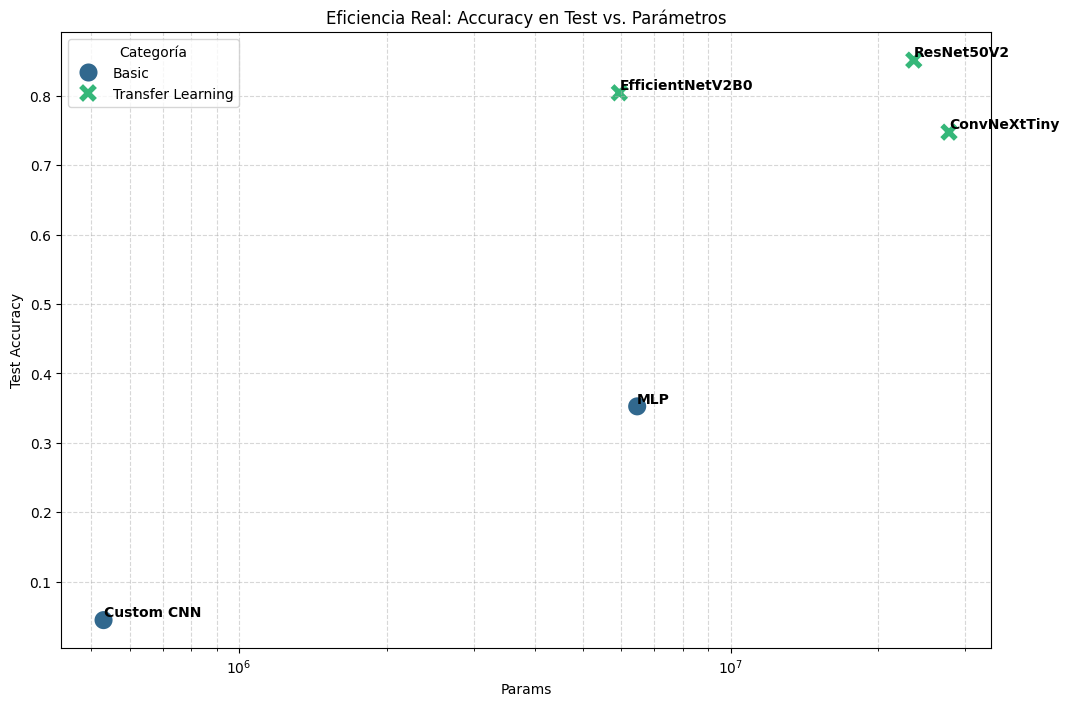

/tmp/ipykernel_55/3955660773.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Overfitting Ratio', y='Modelo', data=df_sorted, palette=colors)


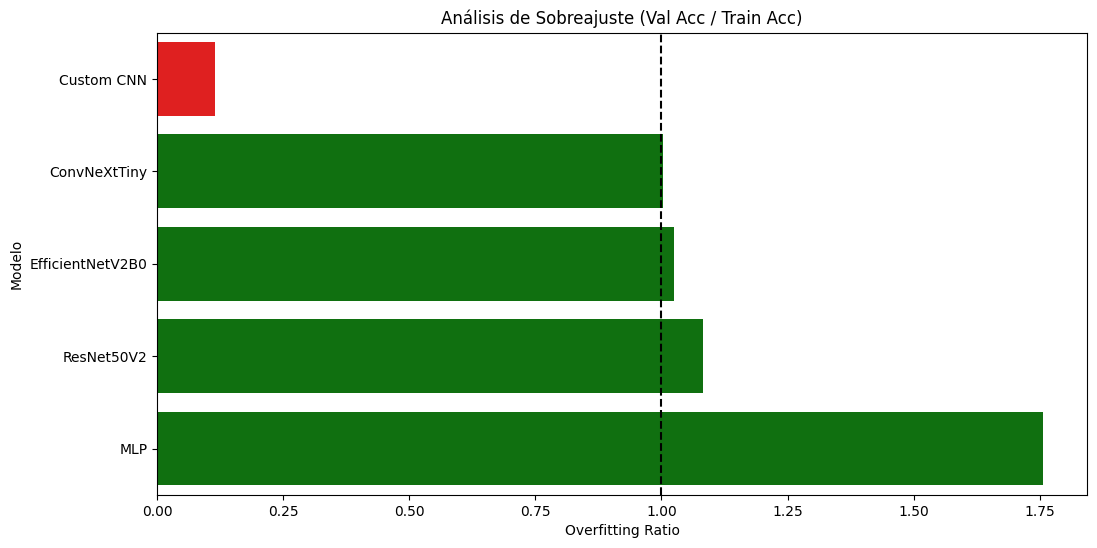


=== Generando Matrices de Confusión (Batch: 16) ===
   Extrayendo etiquetas reales...
   Procesando: ResNet50V2...
   Procesando: EfficientNetV2B0...
   Procesando: ConvNeXtTiny...
   Procesando: MLP...
   Procesando: Custom CNN...


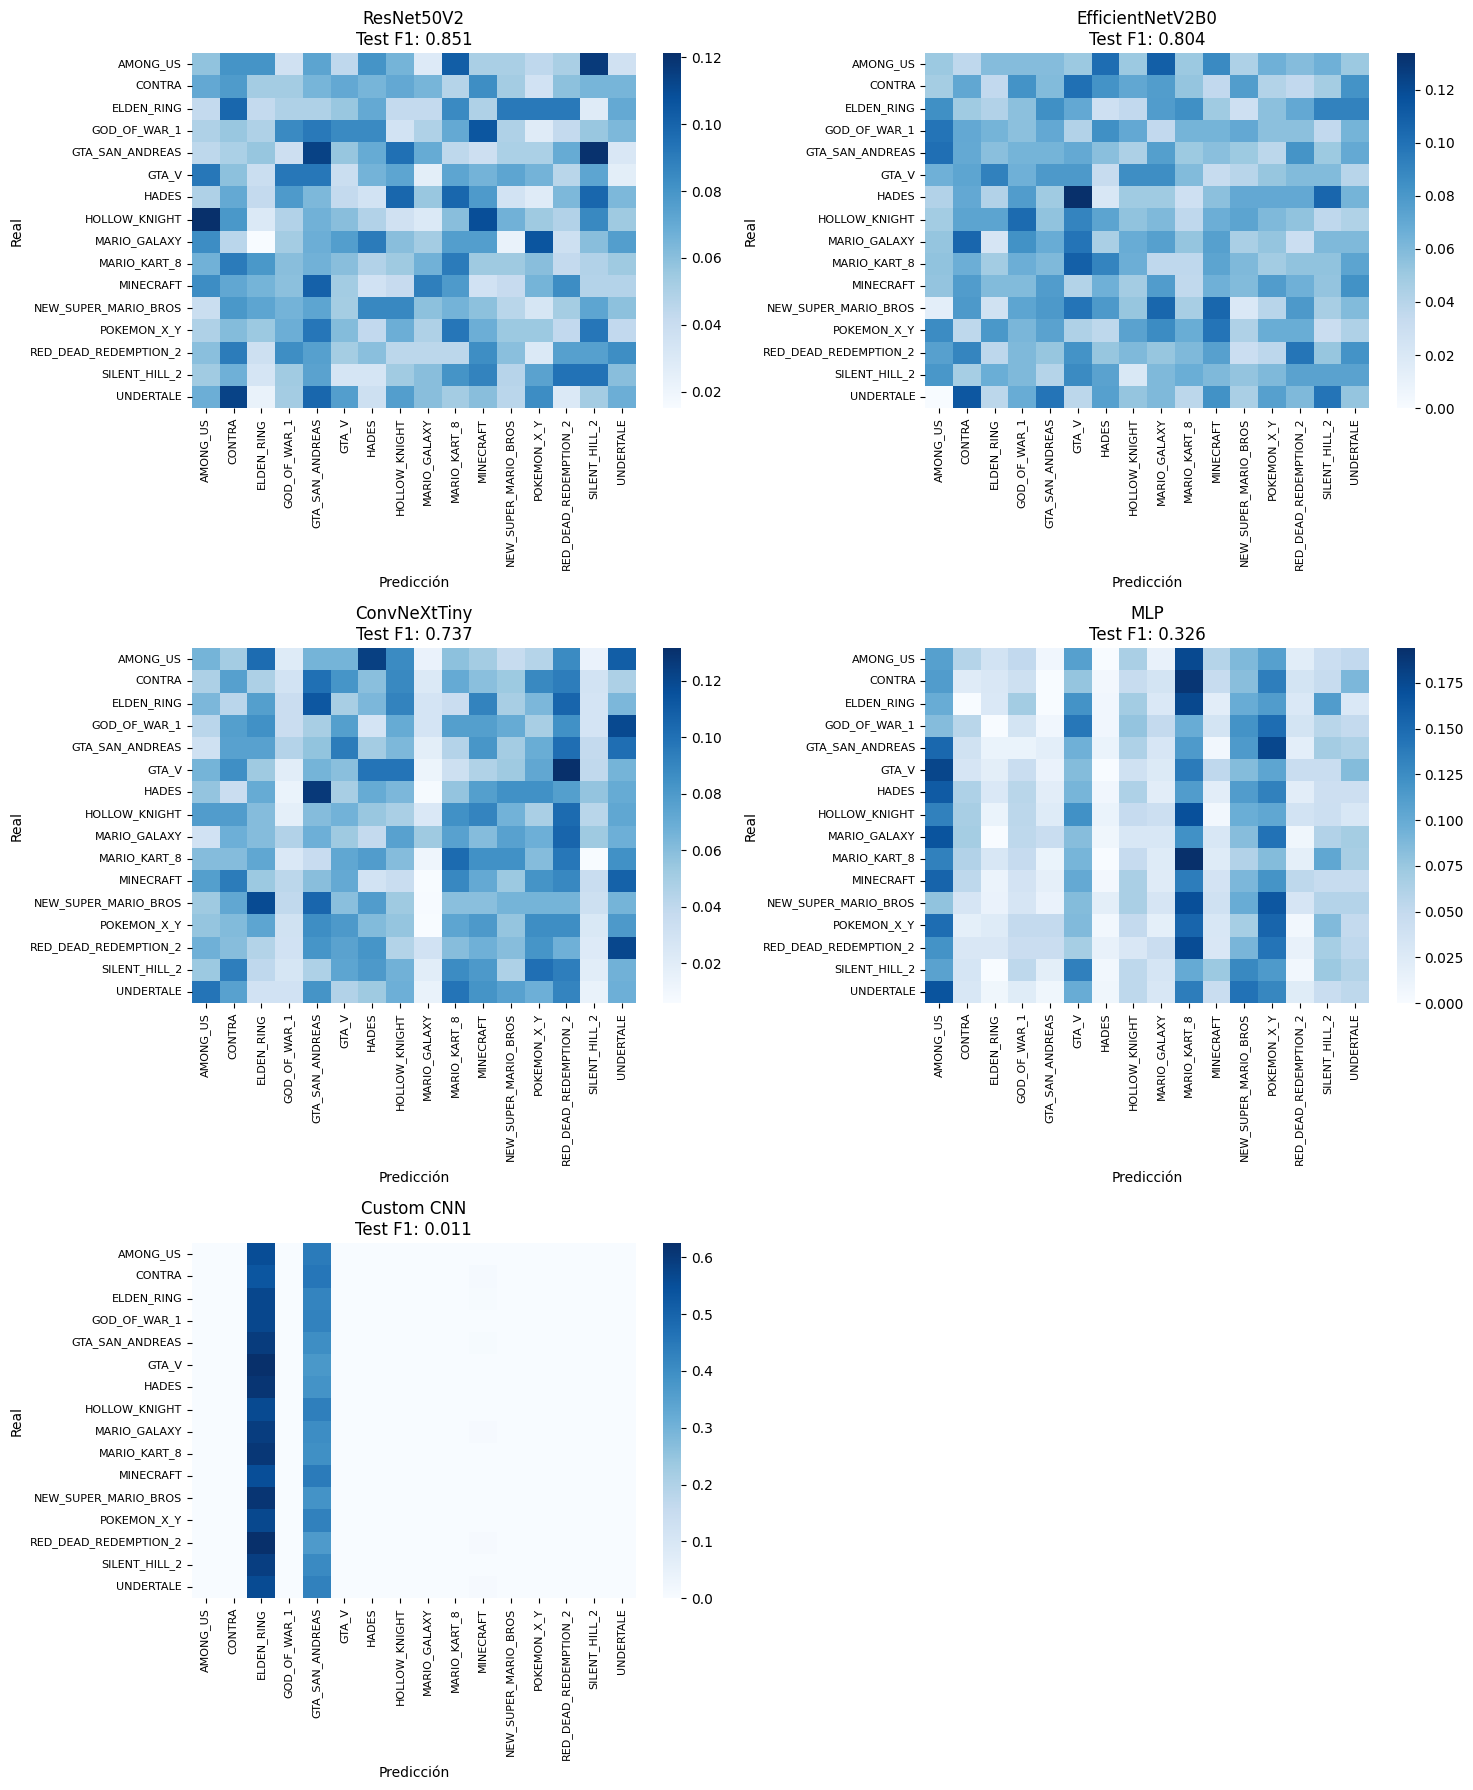

In [ ]:
# Recopilamos las metricas
df_results = gather_comprehensive_metrics(test_ds)

if not df_results.empty:
    # Imprimimos la tabla
    print("\n" + "="*80)
    print(df_results[['Modelo', 'Categoría', 'Params', 'Train Acc', 'Val Acc', 'Test Acc', 'Overfitting Ratio']].to_markdown(index=False, floatfmt=".4f"))
    
    # Gráficas
    plot_efficiency_analysis(df_results)
    plot_overfitting_analysis(df_results)
    
    # Matrices (Usando Test DS)
    compare_confusion_matrices(df_results, test_ds, class_names)
else:
    print("No se generaron resultados.")